In [1]:
import torch
import torch.nn as nn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import numpy as np

import string

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/arturo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/arturo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Importing the dataset

In [4]:
df_test_like = pd.read_csv("en/en_test_like_file.csv")
df_fake = pd.read_csv("en/en_train_fake.csv")
df_true = pd.read_csv("en/en_train_true.csv")

print(f"Fake Samples: {len(df_fake)}, True Samples: {len(df_true)}")

Fake Samples: 18784, True Samples: 17133


In [5]:
#create labels for true(1) and fake(0)
df_fake['labels']=0
df_true['labels']=1

In [6]:
df = pd.concat([df_fake,df_true], ignore_index=True)

In [7]:
df['text'] = df['title'] + ' ' + df['text']
df = df[['text','labels']]

In [8]:
df

,text,labels
0,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,0
1,FLASHBACK: TRUMP PLANS STRATEGY Against North ...,0
2,SHARIA LAWYER: Why Muslims are Less Likely to ...,0
3,Republican Governor Helped Kill 11 Elderly Pe...,0
4,NY Teacher Gives Assignment To High School Kid...,0
...,...,...
35912,Nigeria says U.S. agrees delayed $593 million ...,1
35913,'Nearly man' Ramaphosa edges closer to South A...,1
35914,Trump says sought Flynn's resignation over sta...,1
35915,Republican tax plan would deal financial hit t...,1


# Text preprocessing

In [9]:
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(filtered_tokens)

# Apply preprocessing
df['text'] = df['text'].apply(preprocess)

In [10]:
df

,text,labels
0,video blacklivesmatter terrorists storm dartmo...,0
1,flashback trump plans strategy north korea int...,0
2,sharia lawyer muslims less likely integrate we...,0
3,republican governor helped kill elderly people...,0
4,ny teacher gives assignment high school kids c...,0
...,...,...
35912,nigeria says agrees delayed million fighter pl...,1
35913,man ramaphosa edges closer south africa top jo...,1
35914,trump says sought flynn resignation statements...,1
35915,republican tax plan would deal financial hit u...,1


# Tokenize

In [11]:
tokenizer = get_tokenizer('basic_english') # nltk tokenizer

# Build vocabulary
# count all unique tokens in a dataset and build a vocabulary from that
# keeps vocabularies smaller and domain specific
def build_vocab(dataset: pd.DataFrame):
    counter = Counter()
    for i, row in dataset.iterrows():
        counter.update(tokenizer(row["text"]))
    v = vocab(counter, specials=['<unk>', '<pad>'])
    v.set_default_index(v['<unk>'])
    return v

In [12]:
generator = torch.Generator().manual_seed(42)

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(df, [0.7, 0.15, 0.15], generator=generator)

In [13]:
train_df = df.iloc[train_dataset.indices]
test_df = df.iloc[test_dataset.indices]
val_df = df.iloc[val_dataset.indices]

In [14]:
print(f"{100*train_df['labels'].sum()/len(train_df):.2f} % True on Train")
print(f"{100*test_df['labels'].sum()/len(test_df):.2f} % True on Test")
print(f"{100*val_df['labels'].sum()/len(val_df):.2f} % True on Val")

47.97 % True on Train
48.31 % True on Test
45.85 % True on Val


In [15]:
fakenews_vocab = build_vocab(train_df)

In [16]:
class FakeNewsDataset(Dataset):
    def __init__(self,dataframe,vocab):
        self.dataframe = dataframe
        self.vocab = vocab

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self,idx):
        text = tokenizer(self.dataframe.iloc[idx]['text'])
        label = int(self.dataframe.iloc[idx]['labels'])
        return [self.vocab[token] for token in text], label

train_dataset = FakeNewsDataset(train_df,fakenews_vocab)
test_dataset = FakeNewsDataset(test_df,fakenews_vocab)
val_dataset = FakeNewsDataset(val_df,fakenews_vocab)

In [17]:
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _text, _label in batch:
        label_list.append(_label) # store label for sample
        processed_text = torch.tensor(_text, dtype=torch.int64) # tokens to tensor
        text_list.append(processed_text) # store tensor
        lengths.append(len(processed_text)) # store length of tensor
    label_list = torch.tensor(label_list, dtype=torch.int64) # labels to tensor
    # tensors of different size in same batch -> pad shorter ones
    text_list = pad_sequence(text_list,
                             batch_first=True,
                             padding_value=fakenews_vocab['<pad>'])
    lengths = torch.tensor(lengths, dtype=torch.int64) # lengths to tensor
    return text_list, label_list, lengths


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Model Definition

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self,x, text_lengths):
        embedded = self.embedding(x)
        packed_embedding = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden,_) = self.lstm(packed_embedding)
        hidden = hidden[-1,:,:]
        z = self.fc(hidden)
        return z

In [19]:
vocab_size = len(fakenews_vocab)
embed_dim = 100
hidden_dim = 256
output_dim = 2
num_layers = 2

learning_rate = 1e-3

model = LSTMModel(vocab_size, embed_dim, hidden_dim, output_dim, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
def train_model(n_epochs, model, train_loader, val_loader, optimizer, criterion):
    accuracies = []

    model.to(device)
    
    for i in tqdm(range(n_epochs)):
        for x_train, y_train, lens in train_loader:
            x_train, y_train = x_train.to(device), y_train.to(device)
            lens = lens.to(device)
            
            optimizer.zero_grad()
            z_train = model(x_train, text_lengths=lens)
            loss = criterion(z_train, y_train)
            loss.backward()
            optimizer.step()

        correct = 0
        with torch.no_grad():
            for x_val, y_val, lens in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                lens = lens.to(device)
                
                z_val = model(x_val, text_lengths=lens)
                val_loss = criterion(z_val, y_val)
                
                _,y_pred = torch.max(z_val.data,1)
                correct += (y_pred == y_val).sum().item()

        accuracy = correct/len(val_loader.dataset)
        print(f"Val Acc: {accuracy * 100:.2f}%")
        accuracies.append(accuracy)

    return accuracies
        

In [22]:
len(train_loader)

786

In [24]:
n_epochs = 20

accuracies = train_model(n_epochs,model,train_loader,val_loader,optimizer,criterion)

  5%|██▏                                         | 1/20 [01:12<23:00, 72.67s/it]

Val Acc: 97.27%


 10%|████▍                                       | 2/20 [02:25<21:52, 72.91s/it]

Val Acc: 99.61%


 15%|██████▌                                     | 3/20 [03:38<20:38, 72.84s/it]

Val Acc: 99.70%


 20%|████████▊                                   | 4/20 [04:51<19:24, 72.79s/it]

Val Acc: 99.70%


 25%|███████████                                 | 5/20 [06:04<18:13, 72.88s/it]

Val Acc: 99.57%


 30%|█████████████▏                              | 6/20 [07:16<16:59, 72.81s/it]

Val Acc: 99.67%


 35%|███████████████▍                            | 7/20 [08:29<15:47, 72.86s/it]

Val Acc: 99.70%


 40%|█████████████████▌                          | 8/20 [09:42<14:34, 72.87s/it]

Val Acc: 99.70%


 45%|███████████████████▊                        | 9/20 [10:55<13:21, 72.86s/it]

Val Acc: 99.72%


 50%|█████████████████████▌                     | 10/20 [12:08<12:08, 72.89s/it]

Val Acc: 99.80%


 55%|███████████████████████▋                   | 11/20 [13:21<10:56, 72.97s/it]

Val Acc: 99.68%


 60%|█████████████████████████▊                 | 12/20 [14:36<09:48, 73.53s/it]

Val Acc: 99.68%


 65%|███████████████████████████▉               | 13/20 [15:53<08:41, 74.50s/it]

Val Acc: 99.67%


 70%|██████████████████████████████             | 14/20 [17:08<07:28, 74.81s/it]

Val Acc: 99.65%


 75%|████████████████████████████████▎          | 15/20 [18:23<06:13, 74.78s/it]

Val Acc: 99.61%


 80%|██████████████████████████████████▍        | 16/20 [19:37<04:57, 74.48s/it]

Val Acc: 99.78%


 85%|████████████████████████████████████▌      | 17/20 [20:52<03:43, 74.61s/it]

Val Acc: 99.76%


 90%|██████████████████████████████████████▋    | 18/20 [22:04<02:27, 73.97s/it]

Val Acc: 99.65%


 95%|████████████████████████████████████████▊  | 19/20 [23:17<01:13, 73.65s/it]

Val Acc: 99.59%


100%|███████████████████████████████████████████| 20/20 [24:31<00:00, 73.55s/it]

Val Acc: 99.61%


In [25]:
def evaluate_model(
    model,
    test_loader
):
    model.to(device)
    correct = 0
    preds = []
    trues = []
    
    with torch.no_grad():
        for x_test, y_test, lens in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            lens = lens.to(device)
                
            z_test = model(x_test, text_lengths=lens)
            _,y_pred = torch.max(z_test.data,1)
            correct += (y_pred == y_test).sum().item()
            preds.extend(y_pred.cpu().numpy())
            trues.extend(y_test.cpu().numpy())

    accuracy = correct/len(test_loader.dataset)

    return accuracy, preds, trues

In [26]:
test_accuracy, preds, true = evaluate_model(model,test_loader)

Test Accuracy: 99.72 %


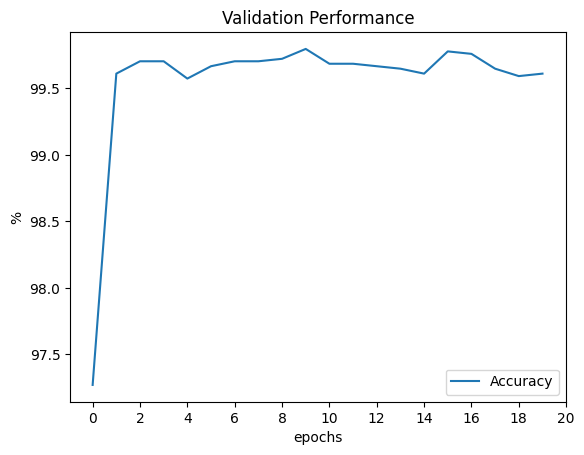

In [28]:
plt.plot(100*np.array(accuracies), label='Accuracy')
plt.title("Validation Performance")
plt.xlabel("epochs")
plt.ylabel("%")
plt.xticks(2*np.array(range(11)))
plt.legend()

print(f"Test Accuracy: {test_accuracy * 100:.2f} %")

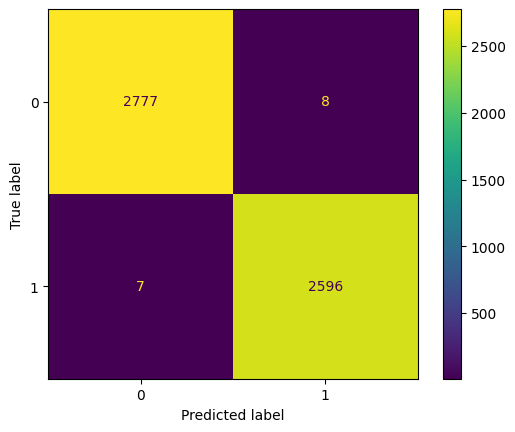

In [30]:
cm = confusion_matrix(true,preds)
mat = ConfusionMatrixDisplay(cm)
mat.plot()

In [31]:
df_fake_new = pd.read_csv("new/Fake.csv")
df_true_new = pd.read_csv("new/True.csv")

print(f"Fake Samples: {len(df_fake_new)}, True Samples: {len(df_true_new)}")

Fake Samples: 23481, True Samples: 21417


In [32]:
#create labels for true(1) and fake(0)
df_fake_new['labels']=0
df_true_new['labels']=1

In [33]:
df_fake_new

,title,text,subject,date,labels
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [34]:
df_new = pd.concat([df_fake_new,df_true_new], ignore_index=True)

In [35]:
df_new['text'] = df_new['title'] + ' ' + df_new['text']
df_new = df_new[['text','labels']]
df_new['text'] = df_new['text'].apply(preprocess)

In [36]:
df_new

,text,labels
0,donald trump sends embarrassing new year eve m...,0
1,drunk bragging trump staffer started russian c...,0
2,sheriff david clarke becomes internet joke thr...,0
3,trump obsessed even obama name coded website i...,0
4,pope francis called donald trump christmas spe...,0
...,...,...
44893,committed nato backs new approach afghanistan ...,1
44894,lexisnexis withdrew two products chinese marke...,1
44895,minsk cultural hub becomes authorities minsk r...,1
44896,vatican upbeat possibility pope francis visiti...,1


In [37]:
new_test_dataset = FakeNewsDataset(df_new,fakenews_vocab)

In [38]:
batch_size = 32
new_test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

In [39]:
test_accuracy, preds, trues = evaluate_model(model,new_test_loader)

In [40]:
print(f"Test Accuracy: {test_accuracy * 100:.2f} %")

Test Accuracy: 99.86 %


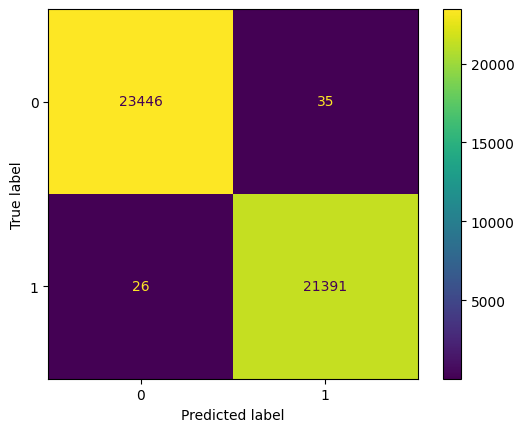

In [41]:
cm = confusion_matrix(trues,preds)
mat = ConfusionMatrixDisplay(cm)
mat.plot()

In [42]:
#Save the model
torch.save(model.state_dict(), "./lstm.pt")